In [1]:
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from itertools import combinations

features.isna().mean().sort_values()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px


In [ ]:
torch.set_default_device('cuda')
torch.set_default_dtype(torch.float32)

### Data Loading

In [3]:
etf_names = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']

In [4]:
df = pd.read_pickle('combied_strats_data.pickle')
df.shape

In [7]:
#df[[i for i in df.columns if 'XLE' in i and 'return' in i]].plot(grid=True, legend=True)
#df['price_XLE'].plot(grid=True, legend=True)

In [9]:
df = df[[i for i in df.columns if 'return' in i]].diff()

In [10]:
df = df.resample('1h').sum()

In [11]:
df = df.fillna(0)

In [12]:
strat_columns = df.columns

### Features engineering

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def count_ewma_correlation(returns_1, returns_2,window = 200):
    alpha = 2 / (window + 1)

    cov_ewma = returns_1.ewm(alpha=alpha).cov(returns_2)
    var_ewma_1 = returns_1.ewm(alpha=alpha).var()
    var_ewma_2 = returns_2.ewm(alpha=alpha).var()

    ewma_corr = cov_ewma / (var_ewma_1 * var_ewma_2) ** 0.5
    return  ewma_corr

features = pd.DataFrame()
for col in strat_columns:
    for window in tqdm([8, 24, 72, 168, 336, 772, 2016, 4032, 8064]):
        features['sum_return_' + col + '_' + str(window)] = df[col].rolling(window).sum().shift(1)
        features['std_return_' + col + '_' + str(window)] = df[col].rolling(window).std().shift(1)
        features['mean_return_' + col + '_' + str(window)] = df[col].rolling(window).mean().shift(1)
        features['abs_return_' + col + '_' + str(window)] = df[col].abs().rolling(window).sum().shift(1)
        features['abs_std_' + col + '_' + str(window)] = df[col].abs().rolling(window).std().shift(1)

for comb in tqdm(list(combinations(strat_columns,2))) :
    features[str(comb)] = count_ewma_correlation(df[comb[0]], df[comb[1]],window = 200).shift(1)

features['day_of_week'] = features.index.dayofweek
features['month'] = features.index.month
features['quarter'] = features.index.quarter
features['hour'] = features.index.hour




In [15]:
features = features.iloc[8065:]
df = df.iloc[8065:]

In [16]:
features = features.ffill()

In [18]:
save_index = features.index
n_components = 400
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(features_scaled)

features = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(n_components)])
features.index = save_index
features.shape

(78582, 400)

### Train-test split

In [20]:
train_data = features[features.index < '15.03.2022']
valid_data = features[(features.index > '17.03.2022') & (features.index < '15.06.2023')]
test_data = features[(features.index > '18.06.2023')]

eq_train = df[df.index < '15.03.2022']
eq_valid = df[(df.index > '17.03.2022') & (df.index < '15.06.2023')]
eq_test = df[df.index > '18.06.2023']

print(train_data.shape, eq_train.shape)
print(valid_data.shape, eq_valid.shape)
print(test_data.shape, eq_test.shape)

(55021, 400) (55021, 27)
(10919, 400) (10919, 27)
(12520, 400) (12520, 27)


### NN preparation

In [ ]:
### NN preparation

In [21]:
class SharpeLoss(nn.Module):
    def __init__(self):
        super(SharpeLoss, self).__init__()

    def forward(self, model_output, eq_data):
        sum_eq = torch.sum((eq_data * model_output), axis=-1)
        total_eq = torch.mean(sum_eq)
        std_sum_eq = torch.std(sum_eq)
        sharpe = total_eq / (std_sum_eq + 1e-66)
        sharpe = torch.mean(sharpe)
        return -sharpe

class SpeedLoss(nn.Module):
    def __init__(self):
        super(SpeedLoss, self).__init__()

    def forward(self, model_output, speed_lim):
        model_output =model_output.view(model_output.shape[0], model_output.shape[1],num_instr ,num_strat  )
        sum_of_changes = torch.sum (torch.abs((model_output[:,1:,:] - model_output[:,:-1,:])), dim=-1)

        with_allowed_speed = torch.relu(sum_of_changes - speed_lim)
        expanented = torch.relu(torch.exp(with_allowed_speed) - 1)
        sum_of_exps = torch.sum(expanented, dim=1)
        total_loss = torch.mean(sum_of_exps)
        return total_loss



class ChangeLoss(nn.Module):
    def __init__(self):
        super(ChangeLoss, self).__init__()

    def forward(self, model_output ):
        out = model_output.view(model_output.shape[0]*model_output.shape[1], model_output.shape[2])
        diversity_penalty =  -torch.var(out, dim=0)

        return torch.mean(diversity_penalty)

In [40]:
class LSTM_NN(nn.Module):
    def __init__(self,
                 num_instr,
                 num_strat,
                 input_size,
                 hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, # , hidden_size6,
                 drop_size, num_layers=5):
        super(LSTM_NN, self).__init__()

        self.num_instr = num_instr
        self.num_strat = num_strat

        self.input_batch_norm = nn.LayerNorm(input_size)

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size1, num_layers, batch_first=True)

        # Dropout layer
        self.dropout1 = nn.Dropout(drop_size)

        # Additional fully connected layers after LSTM
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.batch_norm2 = nn.LayerNorm(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.batch_norm3 = nn.LayerNorm(hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, num_instr * num_strat)

    def forward(self, x):
        """
        :param x: (batch_size, seq_len, num_features) or (seq_len, num_features)
        """
        assert x.ndim in {2, 3}, ValueError(f'{x.shape=} is not supported')

        # Apply batch normalization to input
        x = self.dropout1(x)
        x = self.input_batch_norm(x)

        lstm_out, _ = self.lstm(x)

        x = F.gelu(self.fc2(lstm_out))
        x = self.dropout1(x)
        x = F.gelu(self.batch_norm2(x))
        x = self.fc3(x)
        x = F.sigmoid(x)

        saved_market_regime = x.clone().detach()  # Save the market regime

        x = F.gelu(self.fc4(x))
        x = F.gelu(self.fc5(x))
        x = F.gelu(self.fc6(x))

        x_shape = x.shape
        instr_shape = list(x_shape[:-1]) + [self.num_instr, self.num_strat]
        x = x.view(instr_shape)

        x = F.softmax(x, dim=-1)
        x = x.view(x_shape)
        return x, saved_market_regime

In [41]:
#Hyperparametrs

#global params
num_instr = 9  # number of trading instruments
num_strat = 3  # number of strategies per instrument

#NN parametrs
speed_limit =  0.05 #Avaible change of allcoation of capital inside one instrument without penalty. use SpeedLoss
nn_size = 6
dropout_size = 0.2
lstm_size = 6
sequence_length = 500
batch_size = 3
num_workers = 0

#Training params
learning_rate = 0.001
num_epochs = 3000
#early stop params
patience = 3_00
cur_epohs = 0
tolerance = 0.001




In [42]:
def prep_tensor_lstm(data ,sequence_length):
    time_steps = data.shape[0]
    features = data.shape[1]
    batch = time_steps // sequence_length
    data = data[:batch * sequence_length]

    lstm_prep = data.view(batch, sequence_length, features)

    return lstm_prep

def create_dataloader(inputs, targets, batch_size, shuffle=True):
    dataset = TensorDataset(inputs.to('cuda'), targets.to('cuda'))
    generator_gpu = torch.Generator(device="cuda").manual_seed(42)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, generator=generator_gpu)

In [43]:
train_prep = prep_tensor_lstm(torch.tensor(train_data.to_numpy(), dtype=torch.float32) ,sequence_length)
target_train_prep = prep_tensor_lstm(torch.tensor(eq_train.to_numpy(), dtype=torch.float32),sequence_length)

In [44]:
valid_prep = prep_tensor_lstm(torch.tensor(valid_data.to_numpy(), dtype=torch.float32) ,sequence_length )
target_valid_prep = prep_tensor_lstm(torch.tensor(eq_valid.to_numpy(), dtype=torch.float32),sequence_length)

In [45]:
test_prep = prep_tensor_lstm(torch.tensor(test_data.to_numpy(), dtype=torch.float32) ,sequence_length )
target_test_prep = prep_tensor_lstm(torch.tensor(eq_test.to_numpy(), dtype=torch.float32),sequence_length)

In [47]:

train_loader = create_dataloader(train_prep,
                                 target_train_prep,
                                 batch_size, shuffle=True)
valid_loader = create_dataloader(valid_prep,
                                 target_valid_prep,
                                 batch_size=1, shuffle=False)

test_loader = create_dataloader(test_prep,
                                target_test_prep,
                                batch_size=1, shuffle=False)

### Training

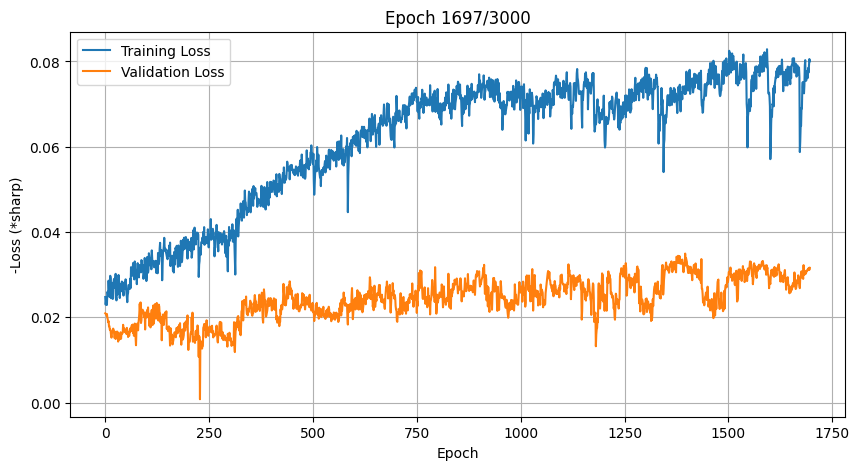

Epoch [1697/3000],
Training Loss: -0.0800,
Validation Loss: -0.0316
Early stopping.
Training complete.


In [48]:

model = LSTM_NN(num_instr=num_instr,
                 num_strat=num_strat,
                 input_size=train_data.shape[1],
                 hidden_size1=32 * nn_size,
                 hidden_size2=16 * nn_size,
                 hidden_size3=2,
                 hidden_size4=16 * nn_size,
                 hidden_size5=32 * nn_size,
                 # hidden_size6=num_instr * num_strat,
                 drop_size=dropout_size,
                 num_layers=lstm_size
                 )
model = model.to(device=torch.get_default_device())
sharpe_loss = SharpeLoss()
speed_loss = SpeedLoss()
change_loss = ChangeLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Initialize learning rate scheduler
lr_warm_start = optim.lr_scheduler.LinearLR(optimizer, start_factor=1/3, end_factor=1.0, total_iters=25)
lr_linear_decay = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0,
                                              end_factor=(learning_rate / 100) / learning_rate, total_iters=num_epochs)

# Training
train_losses, val_losses = [], []
best_score, best_state = None, None

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch_inputs, batch_targets in train_loader:

        batch_inputs, batch_targets = batch_inputs.to('cuda'), batch_targets.to('cuda')
        outputs_train, _ = model(batch_inputs)

        train_sharp_loss = sharpe_loss(outputs_train, batch_targets)
        train_speed_loss = speed_loss(outputs_train, speed_limit)
        train_total_loss = train_sharp_loss+ train_speed_loss

        optimizer.zero_grad()
        train_total_loss.backward()
        optimizer.step()

        total_train_loss += train_total_loss.item()

    lr_warm_start.step()
    lr_linear_decay.step()

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_inputs, batch_targets in valid_loader:

            batch_inputs, batch_targets = batch_inputs.to('cuda'), batch_targets.to('cuda')
            outputs_valid, _ = model(batch_inputs)
            val_sharp_loss = sharpe_loss(outputs_valid, batch_targets)
            val_speed_loss = speed_loss(outputs_valid, speed_limit)
            val_total_loss = val_sharp_loss+ val_speed_loss
            total_val_loss += val_total_loss.item()

    train_losses.append(-total_train_loss / len(train_loader))
    val_losses.append(-total_val_loss / len(valid_loader))

    # Visualization
    clear_output(wait=False)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('-Loss (*sharp)')
    plt.legend()
    plt.grid(True)
    plt.title(f'Epoch {epoch + 1}/{num_epochs}')
    plt.show()

    print(f"Epoch [{epoch + 1}/{num_epochs}],\n"
          f"Training Loss: {total_train_loss / len(train_loader):.4f},\n"
          f"Validation Loss: {total_val_loss / len(valid_loader):.4f}")

    if best_score is None or (total_val_loss < best_score - tolerance):
        best_score = total_val_loss
        best_state = copy.deepcopy(model).cpu().state_dict()
        cur_epohs = 0
    else:
        cur_epohs += 1
    if cur_epohs >= patience:
        print("Early stopping.")
        break

print("Training complete.")


## Quick look on results and save

In [49]:
model.load_state_dict(best_state)
model.to('cuda')

LSTM_NN(
  (input_batch_norm): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
  (lstm): LSTM(400, 192, num_layers=6, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=192, out_features=96, bias=True)
  (batch_norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=96, out_features=2, bias=True)
  (batch_norm3): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
  (fc4): Linear(in_features=2, out_features=96, bias=True)
  (fc5): Linear(in_features=96, out_features=192, bias=True)
  (fc6): Linear(in_features=192, out_features=27, bias=True)
)

<Axes: >

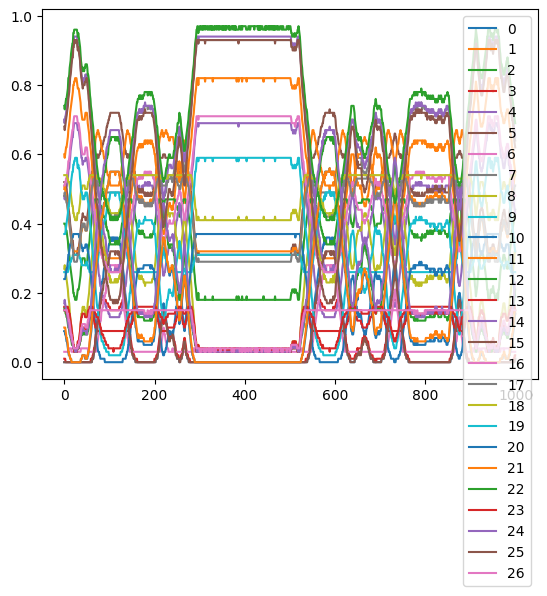

In [50]:
#changing train outputs over time
pd.DataFrame(np.round(outputs_train.view(outputs_train.shape[0]*outputs_train.shape[1],outputs_train.shape[2] ).detach().cpu().numpy(),2)).plot()

In [51]:
strats = []
for batch_inputs, batch_targets in valid_loader:

    batch_inputs, batch_targets = batch_inputs.to('cuda'), batch_targets.to('cuda')
    outputs_valid, _ = model(batch_inputs)
    strats.append(outputs_valid)
outputs_valid = torch.concatenate(strats)

In [55]:
strats = []
regime =[]
targets =[]
for batch_inputs, batch_targets in valid_loader:

    batch_inputs, batch_targets = batch_inputs.to('cuda'), batch_targets.to('cuda')
    outputs_valid, regime_test = model(batch_inputs)
    strats.append(outputs_valid)
    regime.append(regime_test)
    targets.append(batch_targets)
outputs_test = torch.concatenate(strats)
regime_test  = torch.concatenate(regime)
targets_test = torch.concatenate(targets)


<Axes: >

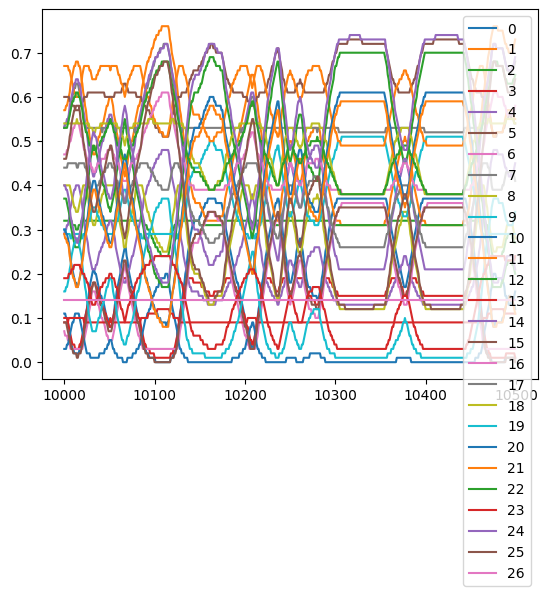

In [105]:
#outputs on test data, last 500 hours
pd.DataFrame(np.round(outputs_test.view(outputs_test.shape[0]*outputs_test.shape[1],outputs_test.shape[2] ).detach().cpu().numpy(),2)).tail(500).plot()

<Axes: xlabel='NYC'>

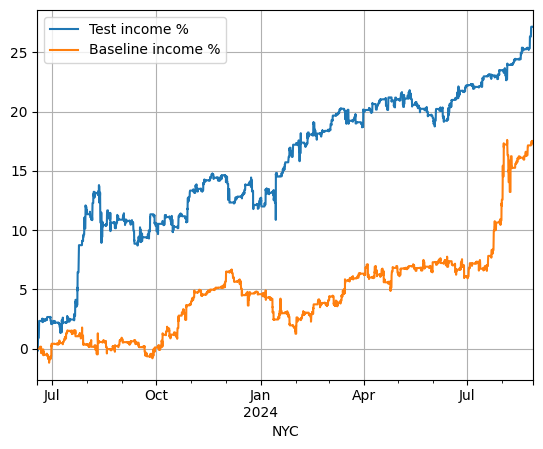

In [107]:
#income compare against baseline
test_final_trades = torch.sum( (outputs_test.view(outputs_test.shape[0]*outputs_test.shape[1], outputs_test.shape[2])* targets_test.view(outputs_test.shape[0]*outputs_test.shape[1], outputs_test.shape[2])),axis=1)
test_final_trades = pd.Series(test_final_trades.detach().cpu().numpy()).cumsum()  #.plot(grid=True)
test_final_trades.index = eq_test.index[:test_final_trades.shape[0]]
test_final_trades = test_final_trades.rename('Test income %')
((test_final_trades *100)/9).plot(legend=True)
((eq_test.sum(axis=1).cumsum() * 1/3)*100/9)[:len(z)].rename('Baseline income %').plot(grid=True, legend=True)

In [58]:
regime_test = regime_test.view(regime_test.shape[0]*regime_test.shape[1], regime_test.shape[2])

In [60]:
reg = pd.DataFrame(regime_test.cpu().detach().numpy())

In [62]:
reg.index = test_data[:len(reg)].index

In [63]:
reg.head()

,0,1
NYC,,
2023-06-18 01:00:00-04:00,0.996526,0.997475
2023-06-18 02:00:00-04:00,0.997127,0.984900
2023-06-18 03:00:00-04:00,0.997794,0.975191
2023-06-18 04:00:00-04:00,0.997949,0.967487
2023-06-18 05:00:00-04:00,0.997917,0.963257


In [176]:
reg.to_pickle('market_regime_test.pickle')

In [ ]:
# Add a frame column for animation
reg['frame'] = range(len(reg))

# Create animated scatter plot
fig = px.scatter(reg, x=0, y=1, animation_frame='frame', title="Scatter Animation",
                 labels={0: "X", 1: "Y"}, height=500, width=400, range_x=[0, 1], range_y=[0, 1])
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 5
fig.show()

<Axes: xlabel='0', ylabel='1'>

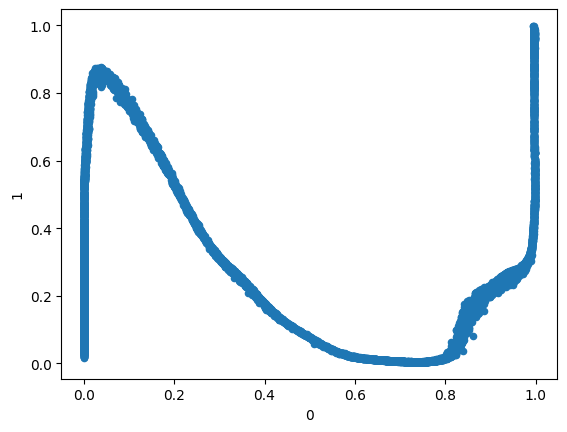

In [69]:
pd.DataFrame(reg).plot.scatter(x=0, y=1)

In [135]:
test_baseline = (eq_test.sum(axis=1).cumsum() * 1/3)[:len(z)] *100/9

In [170]:
def calc_params(test_baseline):
    baseline_yearly_sharp = ((test_baseline.resample('1d').last() - test_baseline.resample('1d').first()).mean() / (test_baseline.resample('1d').last() - test_baseline.resample('1d').first()).std()) * (252**0.5)
    test_baseline_daily = test_baseline.resample('1d').last()
    max_drawdown = ((test_baseline_daily - test_baseline_daily.cummax()) / test_baseline_daily.cummax()).abs().max()

    annual_return = test_baseline_daily.iloc[-1]/(len(set(test_baseline.index.date)) /365)
    return baseline_yearly_sharp, max_drawdown, annual_return

In [172]:
baseline_yearly_sharp, max_drawdown, annual_return = calc_params(test_baseline)
print('Baseline Sharpe',round(baseline_yearly_sharp,3))
print('Baseline max_ddown',round(max_drawdown,3))
print('Baseline annual return', round(annual_return,3))

Baseline Sharpe 1.556
Baseline max_ddown 6.312
Baseline annual return 14.367


In [175]:
baseline_yearly_sharp, max_drawdown, annual_return = calc_params((test_final_trades *100)/9)
print('Test data Sharpe',round(baseline_yearly_sharp,3))
print('Test data max_ddown',round(max_drawdown,3))
print('Test data annual return', round(annual_return,3))

Test data Sharpe 2.193
Test data max_ddown 0.334
Test data annual return 22.627
